In [84]:
import importlib
import utils
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\rohan\\222finalproj\\rohan-isaac-222-proj\\utils.py'>

In [85]:
import pandas as pd
import utils

isaac_df = pd.read_csv("IsaacNetflixHistory.csv")
isaac_df = utils.clean_enriched_netflix_data(isaac_df)
isaac_df.head()

c:\Users\rohan\222finalproj\rohan-isaac-222-proj\utils.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


,Title,Date,Type,Series Name,Season and Episode,Watch Year
0,Breaking Bad: Season 1: Pilot,2025-04-18,Show,Breaking Bad,"Season 1, Episode: Pilot",2025
1,Meet the Parents,2025-04-17,Movie,N/A,N/A,2025
2,Meet the Fockers,2025-04-16,Movie,N/A,N/A,2025
3,Suits: Season 1: Play the Man,2025-04-09,Show,Suits,"Season 1, Episode: Play the Man",2025
4,Suits: Season 1: Tricks of the Trade,2025-04-09,Show,Suits,"Season 1, Episode: Tricks of the Trade",2025


In [86]:
import pandas as pd
import utils

rohan_df = pd.read_csv("RohanNetflixHistory.csv")
rohan_df = utils.clean_enriched_netflix_data(rohan_df)
rohan_df.head()


,Title,Date,Type,Series Name,Season and Episode,Watch Year
0,"High-Rise Invasion: I'm Sorry, Mayuko Nise",2025-02-11,Show,High-Rise Invasion,"I'm Sorry, Mayuko Nise",2025
1,High-Rise Invasion: I've Found a New Goal,2025-02-11,Show,High-Rise Invasion,I've Found a New Goal,2025
2,Suits: Season 1: Identity Crisis,2025-02-11,Show,Suits,Season 1: Identity Crisis,2025
3,Suits: Season 1: Play the Man,2025-02-11,Show,Suits,Season 1: Play the Man,2025
4,The Night Agent: Season 2: Disconnected,2025-02-11,Show,The Night Agent,Season 2: Disconnected,2025


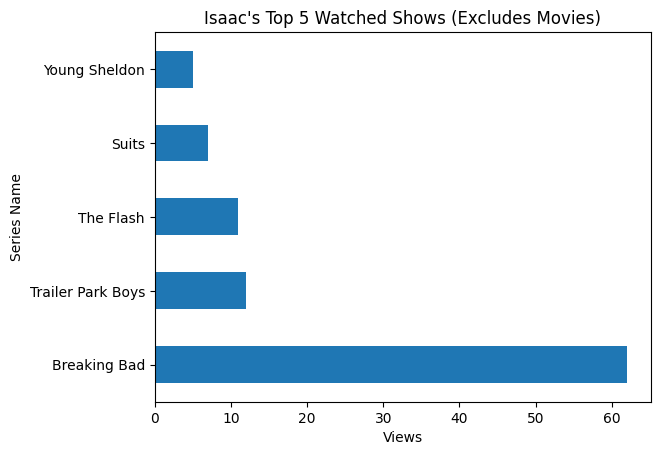

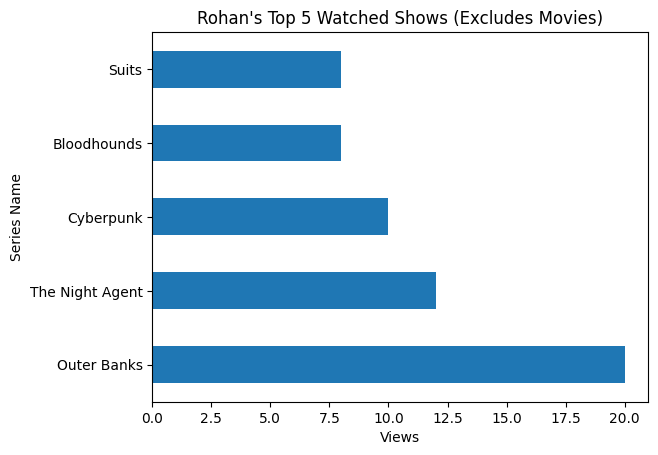

In [71]:
import matplotlib.pyplot as plt

# Isaac's top 5 shows (exclude movies)
isaac_shows = isaac_df[isaac_df['Type'] == 'Show']
isaac_shows['Series Name'].value_counts().head(5).plot(kind='barh')
plt.title("Isaac's Top 5 Watched Shows (Excludes Movies)")
plt.xlabel('Views')
plt.ylabel('Series Name')
plt.show()

rohan_shows = rohan_df[rohan_df['Type'] == 'Show']
rohan_shows['Series Name'].value_counts().head(5).plot(kind='barh')
plt.title("Rohan's Top 5 Watched Shows (Excludes Movies)")
plt.xlabel('Views')
plt.ylabel('Series Name')
plt.show()



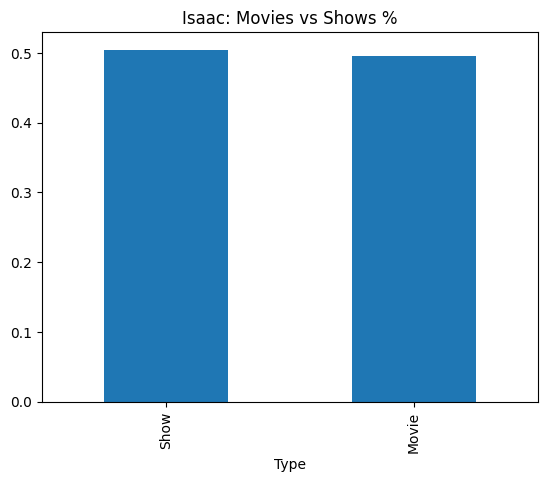

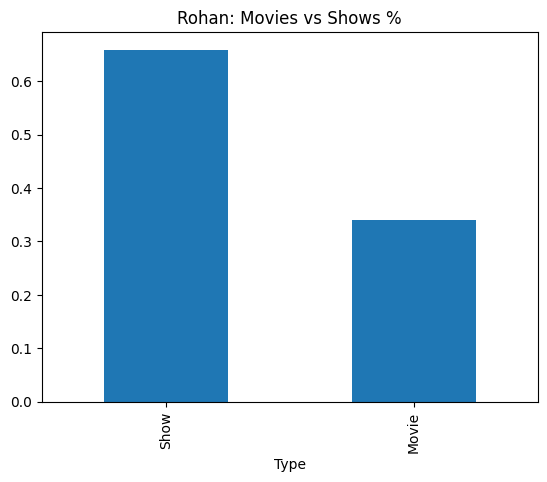

In [52]:
isaac_df['Type'].value_counts(normalize=True).plot(kind='bar', title="Isaac: Movies vs Shows %")
plt.show()
rohan_df['Type'].value_counts(normalize=True).plot(kind='bar', title="Rohan: Movies vs Shows %")
plt.show()

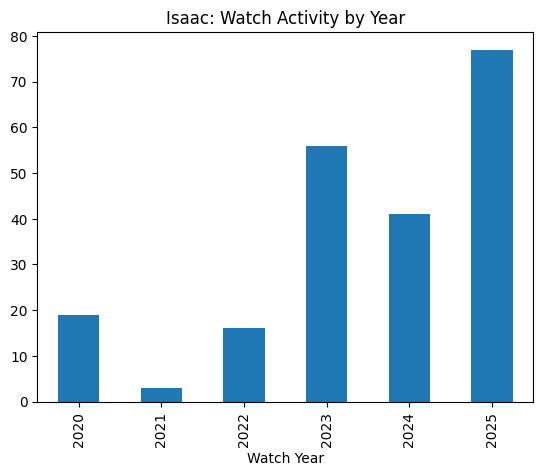

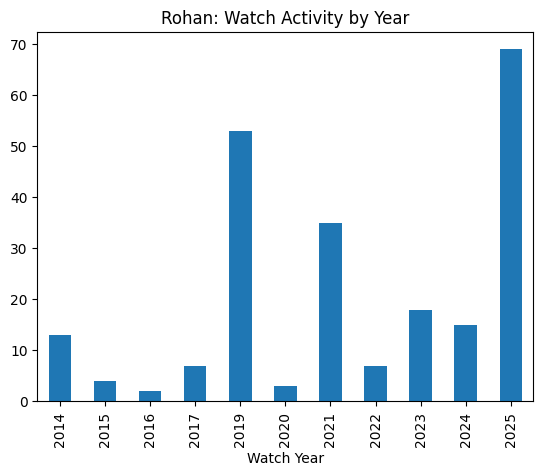

In [72]:
isaac_df['Watch Year'].value_counts().sort_index().plot(kind='bar', title="Isaac: Watch Activity by Year")
plt.show()
rohan_df['Watch Year'].value_counts().sort_index().plot(kind='bar', title="Rohan: Watch Activity by Year")
plt.show()

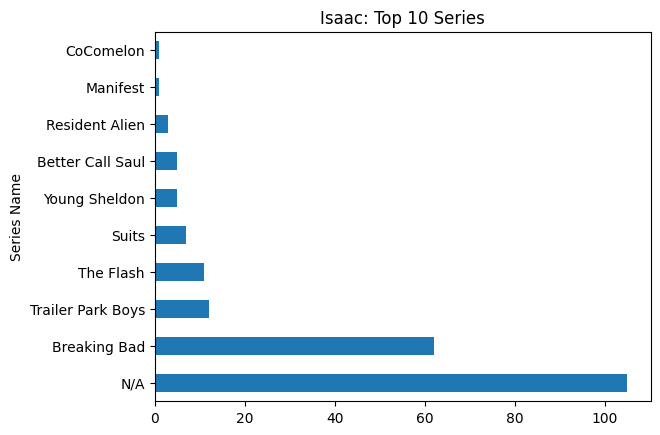

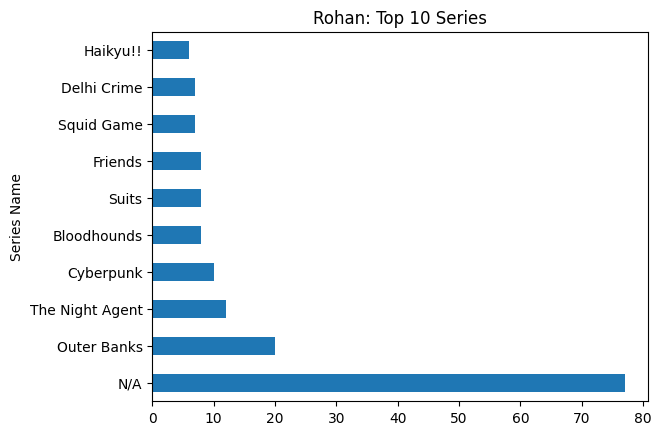

In [74]:
isaac_df['Series Name'].value_counts().head(10).plot(kind='barh', title="Isaac: Top 10 Series")
plt.show()
rohan_df['Series Name'].value_counts().head(10).plot(kind='barh', title="Rohan: Top 10 Series")
plt.show()

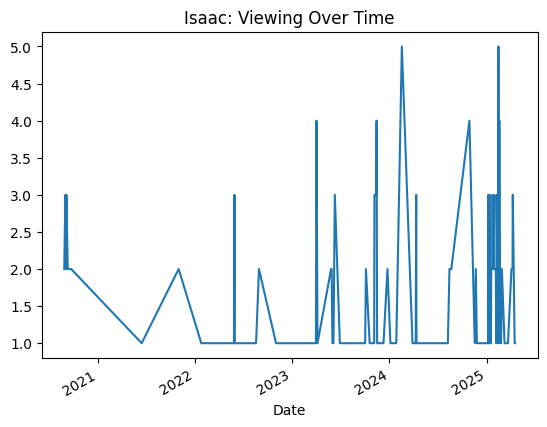

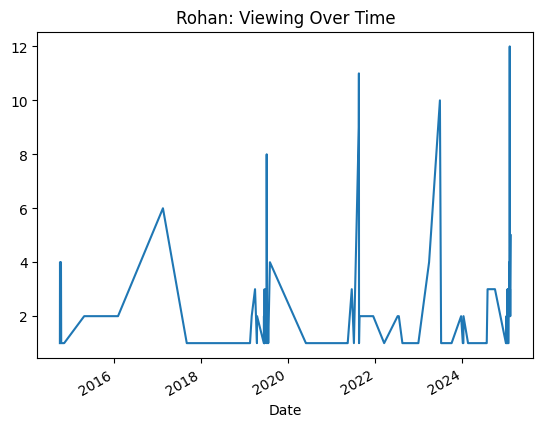

In [73]:
isaac_df['Date'].value_counts().sort_index().plot(kind='line', title="Isaac: Viewing Over Time")
plt.show()
rohan_df['Date'].value_counts().sort_index().plot(kind='line', title="Rohan: Viewing Over Time")
plt.show()

In [75]:
from scipy.stats import ttest_ind

# 1) filter to 2024 watches
isaac_24 = isaac_df[isaac_df['Watch Year'] == 2024]
rohan_24 = rohan_df[rohan_df['Watch Year'] == 2024]

# 2) build 0/1 series for “Show”
isaac_binary = (isaac_24['Type'] == 'Show').astype(int)
rohan_binary = (rohan_24['Type'] == 'Show').astype(int)

# 3) run Welch’s t-test
t_stat, p_value = ttest_ind(isaac_binary, rohan_binary, equal_var=False)

# 4) output test statistics
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.4f}")

# 5) one-sided decision rule at α = 0.05
alpha = 0.05
if (t_stat > 0) and (p_value/2 < alpha):
    print("Reject H₀: Isaac watched a higher proportion of shows in 2024 than Rohan.")
else:
    print("Fail to reject H₀: Not enough evidence that Isaac watched more shows in 2024.")

T-statistic: 0.975
P-value: 0.3373
Fail to reject H₀: Not enough evidence that Isaac watched more shows in 2024.
